# Import Core Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from os import listdir, walk
from os.path import isfile, join

## Define Methods to be Used

In [51]:
def calc_sec(time):
    hms = time.split(':')
    hms = [float(x) for x in hms]
    sec = hms[2] + hms[1]*60 + hms[0]*3600
    sec = round(sec,3)
    return sec

In [52]:
def calc_ts(sec):
    ts = ''
    hr = int(sec/3600)
    mn = int((sec - (hr*3600))/60)
    sc = sec - (hr*3600) - (mn*60)
    sc = round(sc,3)
    ts += str(hr) + ':' + str(mn) + ':' + str(sc)
    # print(ts)
    return ts

In [53]:
def calc_t_period(dates,secs):
    t_period = []
    
    start_sec = secs[0]
    prev_sec = secs[0]
    prev_date = dates[0]

    for i in range(len(secs)):
        curr_sec = secs[i]
        diff_sec = curr_sec - prev_sec
        curr_date = dates[i]
        
        if((diff_sec>3.0) and (curr_date==prev_date)):
            t_period.append([curr_date,start_sec,prev_sec])
            start_sec = curr_sec
        elif(curr_date!=prev_date):
            t_period.append([prev_date,start_sec,prev_sec])
            start_sec = curr_sec
            prev_date = curr_date
        elif(i==len(secs)-1):
            t_period.append([curr_date,start_sec,curr_sec])

        prev_sec = curr_sec
    
    return t_period

In [54]:
def equation_bai(X_i):
    all_std = []
    
    std_i = np.std(X_i,axis=0)
    diff_std = std_i**2 - std_i_bar**2
    diff_std = (diff_std + 1) / (std_i_bar**2 + 1)
    
    diff_std_ = std_i**2

    all_std.append(diff_std)
    
    all_std = np.array(all_std)
    
    ai = np.sum(all_std**2,axis=1)/3
    ai[ai<0] = 0
    ai = np.sqrt(ai)
    
    return ai

In [55]:
std_i_bar = [0.00349329,0.00465817,0.00543154]
std_i_bar = np.array(std_i_bar)

# Load Dataset

In [56]:
# Retrieve file directories from Google Drive
mypath = 'DDC_Data/'
basepath = ''

dir_ = [f for f in walk(mypath)]
# print(dir_)

dir = list(dir_[0])
dir[1] = sorted(dir[1])

outer_path = dir[0]
sub_path = dir[1]

folders = [join(outer_path,d) for d in sub_path]

files = []
for fd in folders:
    temp_f = [f for f in listdir(fd) if isfile(join(fd, f)) and f[-3:]=='csv' and f[5:9]!='data' and f[:4]==fd[-4:]]
    temp_f = sorted(temp_f)

## Retrieve All Timestamp Periods from a File

In [57]:
all_subjects = []

for i in range(1001,1009):
    all_subjects.append(str(i))

for i in range(2001,2003):
    all_subjects.append(str(i))

print(all_subjects)

['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '2001', '2002']


### Identify Subject ID

In [58]:
def identify_subj_id(i):
    subject_id = all_subjects[i]

    directory = basepath + 'Graphs/' + subject_id

    if(not os.path.exists(directory)):
        os.makedirs(directory)

    return subject_id  

In [59]:
def load_timer(subject_id):
  # Configure starting and ending time values
    sid_dir = mypath + '/' + subject_id
    sid_files = [f for f in listdir(sid_dir) if f[5:11]=='iphone']

    sid_filepath = sid_dir + '/' + sid_files[0]

    # Timestamp periods dataframe
    timer_df = pd.read_csv(sid_filepath, header=None, names=['sid','label', 'timestamp', 'duration'])

    filtered_timer = [i for i in timer_df['sid'] if i==int(subject_id)]

    timer_filt = timer_df[timer_df['sid'].isin(filtered_timer)]
    timer_filt = timer_filt.reset_index(drop=True)

    start_ts = timer_filt.loc[0]['timestamp']
    end_ts = timer_filt.loc[len(timer_filt)-1]['timestamp']

    rec_date = start_ts[:10]
    start_time = start_ts[11:]
    end_time = end_ts[11:]

    return timer_filt, rec_date, start_time, end_time

## Create Pandas DataFrame

In [60]:
def load_acc(subject_id):
    # Load accelerations
    acc_filepath = mypath + '/' + subject_id + '/' + subject_id + '-log_acc.csv'

    df = pd.read_csv(acc_filepath, header=None, names=['x','y','z','timestamp'])

    filtered = [i for i in df['timestamp'] if i[:10]==rec_date and calc_sec(i[11:])>=calc_sec(start_time) 
              and calc_sec(i[11:])<=calc_sec(end_time)]

    df_filt = df[df['timestamp'].isin(filtered)]
    df_filt = df_filt.reset_index(drop=True)

    cols = ['timestamp','x','y','z']
    df_filt = df_filt[cols]

    return df_filt

In [61]:
def load_hr(subject_id):
    # Load heart rate
    hr_filepath = mypath + '/' + subject_id + '/' + subject_id + '-log_hr.csv'

    df2 = pd.read_csv(hr_filepath, header=None, names=['hr','timestamp'])

    filtered = [i for i in df2['timestamp'] if i[:10]==rec_date and calc_sec(i[11:])>=calc_sec(start_time) 
              and calc_sec(i[11:])<=calc_sec(end_time)]

    df_hr = df2[df2['timestamp'].isin(filtered)]
    df_hr = df_hr.reset_index(drop=True)

    cols = ['timestamp','hr']
    df_hr = df_hr[cols]

    return df_hr

In [62]:
def preprocess_ai_data(df_filt, df_hr):
    # Fill in missing HRs
    hr_cnt = 0

    for i in range(len(df_filt)):
        hr_time = df_hr.loc[hr_cnt,'timestamp'].split(' ')[1]
        filt_time = df_filt.loc[i,'timestamp'].split(' ')[1]

        if(calc_sec(hr_time)<=calc_sec(filt_time)):
            if(hr_cnt<len(df_hr)-1):
                hr_cnt += 1
        df_filt.loc[i,'HR'] = df_hr.loc[hr_cnt,'hr']

    # Normalize by dividing by g (standard gravity)
    g = 9.8
    df_filt.loc[:,'x'] = df_filt['x'].apply(lambda x: x/g)
    df_filt.loc[:,'y'] = df_filt['y'].apply(lambda x: x/g)
    df_filt.loc[:,'z'] = df_filt['z'].apply(lambda x: x/g)

    return df_filt

# Calculate Activity Index

In [63]:
def calc_ai(df1):
    H = 10
    ai1 = []

    for i in range(len(df1)):
        xyz_val = []
        if(i-H>=0):
            for j in range(H,0,-1):
                xyz_val.append([df1.iloc[i-j,1],df1.iloc[i-j,2],df1.iloc[i-j,3]])
            ai_val = float(equation_bai(xyz_val))
            ai1.append(ai_val)
        else:
            ai1.append(1)

    return ai1

## Colors for Each Acitivity

In [64]:
def prepare_time_periods(timer_filt):
    t_ = [calc_sec(t.split(' ')[1]) for t in timer_filt['timestamp']]
    duration = [d for d in timer_filt['duration']]
    lb_ = [lb for lb in timer_filt['label']]

    t_end = [t_[i]+calc_sec(duration[i]) for i in range(len(t_))]  

    ts_ = []
    labels = []

    for i in range(len(t_)):
        ts_.append(calc_sec(duration[i]))
        labels.append(lb_[i])
        if(i+1<len(t_)-1):
            ts_.append(round(t_[i+1]-t_end[i],3))
            labels.append('NaN')

    return ts_, labels

In [65]:
def prepare_color_labels(ts_, labels):
  
    accum = 0
    ts = []
    for x in ts_:
        accum += x
        ts.append(round(accum,3))

    lb_set = set()
    for x in labels:
        lb_set.add(x)

    lb_ = list(lb_set)

    set_cnt = []
    for i in range(len(lb_)):
        set_cnt.append(0)

    lb = []
    lb.append('NaN')

    for x in labels:
        for i in range(len(lb_)):
            if(lb_[i]==x and set_cnt[i]!=1 and lb_[i]!='NaN'):
                set_cnt[i] = 1
                lb.append(x)

    colors = ['#808080', '#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
            '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#008080', '#E6BEFF', 
            '#9A6324', '#800000', '#AAFFC3', '#808000', '#000075']

    color_dict = {}
    for i in range(len(lb)):
        color_dict[lb[i]] = colors[i]

    #   print(color_dict)

    lb_color = []
    for x in labels:
        lb_color.append(color_dict[x])

    return ts, lb_color

## Plot Acc, AI with Colors

In [130]:
def plot_ai(df1, ts, lb_color):
    dict1 = df1.to_dict(orient='list')

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
    fig.tight_layout()

    ts_cnt = 0
    x_axis = []
    y_ai = []

    ax = axes[0]
    ax.plot(dict1['x'],color='r',label='X')
    ax.plot(dict1['y'],color='g',label='Y')
    ax.plot(dict1['z'],color='b',label='Z')
    ax.legend(loc='upper right')
    ax.set_title('X,Y,Z')

    ax = axes[1]
    for i in range(len(dict1['timestamp'])):
        if(dict1['AI'][i]>0):
            if(calc_sec(dict1['timestamp'][i].split(' ')[1])>calc_sec(start_time)+ts[ts_cnt]):
                ax.plot(x_axis,y_ai,color=lb_color[ts_cnt])
                ts_cnt += 1
                x_axis = []
                y_ai = []

            elif(ts_cnt==len(lb_color)-1):
                ax.plot(x_axis,y_ai,color=lb_color[ts_cnt])

            x_axis.append(i)
            y_ai.append(dict1['AI'][i])

    ax.set_title('Activity Index')

    fig.savefig(basepath + 'Graphs/' + subject_id + '/' + subject_id + '_ddc_run.png', dpi = 300)

    #   plt.show()
    plt.close(fig)

# AI Function

In [67]:
def ai(subject_id):
    df_filt = load_acc(subject_id)
    df_hr = load_hr(subject_id)

    df1 = preprocess_ai_data(df_filt, df_hr)
    ai1 = calc_ai(df1)

    df1['AI'] = pd.Series(ai1)

    ts_, labels = prepare_time_periods(df_timer)
    ts, lb_color = prepare_color_labels(ts_, labels)

    #   print(ts_, lb_color)

    return df1, ai1, ts, lb_color

# Separate by Labels of Activity

In [68]:
class period:
    def __init__(self, s, f):
        self.s = s
        self.f = f

In [69]:
def separate_label(df1, df_timer, df_list, labels):
  
    df_label = df_timer.groupby('label')
    td_col = ['timestamp','duration']

    for x in df_label:
    # x[0] is a label
    # x[1] is a groupby object

        df_label_x = df_label.get_group(x[0])
        df_label_x = df_label_x.reset_index(drop=True)

        temp_ts = [period(df_label_x.loc[a]['timestamp'].split(' ')[1], 
                    calc_ts( calc_sec(df_label_x.loc[a]['timestamp'].split(' ')[1])+calc_sec(df_label_x.loc[a]['duration']) )) 
                    for a in range(len(df_label_x))]

        for a in temp_ts:
            filter_ = [i for i in df1['timestamp'] 
                    if calc_sec(i.split(' ')[1])>=calc_sec(a.s) and calc_sec(i.split(' ')[1])<=calc_sec(a.f)]

            df1_new = df1[df1['timestamp'].isin(filter_)]
            df1_new = df1_new.reset_index(drop=True)

            for i in range(len(labels)):
                if(labels[i]==x[0]):
                    df_list[i] = df_list[i].append(df1_new)

    return df_list    

## Dataframe List Grouped by Label

In [70]:
def group_dataframe(df1, df_timer):
    df_list = []
    cols = ['timestamp','x','y','z','HR','AI']

    lbl = set()
    for tm in range(len(df_timer)):
        lbl.add(df_timer.loc[tm]['label'])

    LABELS = sorted(list(lbl))

    # dictionary mapped from activity label to index
    label_dict = {
      'downstairs': 0,
      'sit': 1,
      'sleep': 2,
      'stand': 3,
      'upstairs': 4,
      'walk': 5
    }

    for i in range(len(LABELS)):
        df_null = pd.DataFrame(columns=cols)
        df_null = df_null.fillna(0)

        df_list.append(df_null)

    df_list = separate_label(df1, df_timer, df_list, LABELS)

    for i in range(len(df_list)):
        df_list[i] = df_list[i].reset_index(drop=True)

    return df_list, label_dict

## Show Plots of Grouped Dataframe

In [71]:
def plot_grouped_df(df_list, label_dict):
    xyz = ['x','y','z']
    xyz_color = ['r','g','b']

    for x in label_dict:
    #     print(label_dict[x])

        figure = plt.figure(figsize=(20,6))
        figure.tight_layout()

        cnt = 1

        for i in range(len(xyz)):
            ax = plt.subplot(1, len(xyz), cnt)

            ax.set_ylim(top=1.5, bottom=-3.0)
            ax.plot(df_list[label_dict[x]][xyz[i]], label=xyz[i], color=xyz_color[i])
            ax.legend(loc='upper right')
            ax.set_title(xyz[i] + '-axis for activity ' + x + ' subject no. ' + subject_id)

            cnt += 1

        figure.savefig(basepath + 'Graphs/ddc_' + x + '/' + subject_id + '.png', dpi=300)

    #     plt.show()

    # close the figure
    plt.close(figure) 

# SVM Classification

In [81]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, label_binarize, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Get X and y from Dataset for Each Subject

In [83]:
def get_training_data(df_list, label_dict):
    feature_cols = ['x','y','z']
    count = 0

    for x in label_dict:
    #     print(x)
    
        X_series = df_list[label_dict[x]][feature_cols]
        y_series = [label_dict[x] for i in range(len(df_list[label_dict[x]]))]

        X_train = X_series.values.reshape((len(X_series),3))
        y_train = np.array(y_series)

          # 'downstairs': 0,
          # 'sit': 1,
          # 'sleep': 2,
          # 'stand': 3,
          # 'upstairs': 4,
          # 'walk': 5
            
        if(count==0):
            X_train_axes = X_train
            y_train_axes = y_train
            count += 1

        else:
            X_train_axes = np.vstack((X_train_axes, X_train))
            y_train_axes = np.hstack((y_train_axes, y_train))

    X_train_axes = np.array(X_train_axes)
    y_train_axes = np.array(y_train_axes)
    #     print(length)

    return X_train_axes, y_train_axes


## Wavelet Denoising

In [84]:
import pywt
import seaborn

from statsmodels.robust import mad

In [85]:
def wavelet_smooth( x, wavelet="db4", level=1, title=None, color=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="periodic" )
    
    # calculate a threshold
    sigma = mad( coeff[-level] )
    
    # sqtwolog threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="periodic" )
    
    f, ax = plt.subplots()
    plt.plot(x)
    plt.plot(y)
    
#     plt.show()
    plt.close(f)
    
    return y

## Calculate Roll, Pitch, Yaw

In [86]:
def calc_rpy(y, subject_id, colors):
    y_t = y.transpose()
    
    ax = np.array(y_t[0])
    ay = np.array(y_t[1])
    az = np.array(y_t[2])

    rpy = []
    rpy_labels = ['pitch','roll','yaw']

    pitch = 180 * np.arctan(ax/np.sqrt(ay*ay + az*az))/math.pi
    rpy.append(pitch)

    roll = 180 * np.arctan(ay/np.sqrt(ax*ax + az*az))/math.pi
    rpy.append(roll)

    yaw = 180 * np.arctan(az/np.sqrt(ax*ax + ay*ay))/math.pi
    rpy.append(yaw)

    figure, axes = plt.subplots(nrows=TRIAXIAL, ncols=1, figsize=(16,15))

    for i in range(TRIAXIAL):
        ax = axes[i]
        ax.plot(rpy[i],color=colors[i] ,label=rpy_labels[i])
        ax.legend(loc='upper right')
        ax.set_ylim(top=95, bottom=-95)
        ax.set_title(rpy_labels[i] + ' for subject id: ' + subject_id)

    figure.savefig(basepath + 'Graphs/' + subject_id + '/' + subject_id + '_ddc_rpy.png', dpi=300) 

#     plt.show()
    plt.close(figure)

    return roll, pitch, yaw

## Normalize Data

In [138]:
from scipy import stats

In [149]:
def normalize_data(X):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_norm = []
    
    for i in range(len(X_label)):
        X_lb = []
        for X_subj in X_label[i]:
            X_tp = np.array(X_subj).transpose()
            X_a = []
            for X_axis in X_tp:
                X_n = stats.zscore(X_axis)
                X_a.append(X_n)
            X_a = np.array(X_a).transpose()
            X_lb.append(X_a)
            
        X_norm.append(X_lb)
    
    return np.array(X_norm)

## PCA, LDA, and SVD

In [206]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mpl_toolkits.mplot3d import Axes3D

In [214]:
def apply_pca(X, y, target_names):
    n_comp = 3

    pca = PCA(n_components=n_comp)
    X_r = pca.fit(X).transform(X)
#     print(pca.fit(X).components_)
    
    lw = 1
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111, projection='3d')
    
    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5], target_names): 
        
        ax.scatter(X_r[np.where(y==i), 0], X_r[np.where(y==i), 1], X_r[np.where(y==i), 2],
                   color=color, alpha=.8, linewidths=lw, label=target_name)
        ax.legend(loc='best', shadow=False, scatterpoints=1)

    plt.show()
    plt.close(f)

    return np.array(X_r)

In [210]:
def apply_lda(X, y, target_names):
    n_comp = 3

    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    X_r = lda.fit(X, y).transform(X)
    #   print(X_r.shape)

    lw = 1
    fig, ax = plt.subplots(figsize=(10,6))

    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5], target_names):  
        ax.scatter(X_r[np.where(y==i), 0], X_r[np.where(y==i), 1], color=color, alpha=.8, linewidths=lw,
                      label=target_name)
        ax.legend(loc='best', shadow=False, scatterpoints=1)

    plt.show()
    plt.close(f)

    return np.array(X_r)

In [90]:
def apply_svd(X, y, target_names):
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    return u, s, vh

## Support Vector Classification

In [91]:
from sklearn.svm import SVC

In [92]:
def svm_classifier(X, y):
    clf = SVC(kernel='rbf', decision_function_shape='ovr', gamma='auto')
    clf.fit(X, y)

    return clf

# Function Call *

## Aggregate All Data for Each Subject

In [93]:
itr = len(all_subjects)
TRIAXIAL = 3
itr_count = 0

for idx in range(itr):
  
    subject_id = identify_subj_id(idx)
    print(subject_id)

    df_timer, rec_date, start_time, end_time = load_timer(subject_id)
    df1, ai1, ts, lb_color = ai(subject_id)

    # get a list of dataframe in which there are 6 types of activity
    df_list, label_dict = group_dataframe(df1, df_timer)
    label_list = sorted(list(label_dict.keys()))

#     plot_grouped_df(df_list, label_dict)
#     plot_ai(df1, ts, lb_color)

    X_i, y_i = get_training_data(df_list, label_dict)
    subj_i = [subject_id for i in range(len(X_i))]
    
    if(itr_count==0):
        X_all = X_i
        y_all = y_i
        subj_all = subj_i
    else:
        X_all = np.vstack((X_all, X_i))
        y_all = np.hstack((y_all, y_i))
        subj_all = np.hstack((subj_all, subj_i))
    itr_count += 1

print()

1001
1002
1003
1004
1005
1006
1007
1008
2001
2002



In [132]:
# denoise the signal using wavelet transform
# wavelet_output = wavelet_smooth(X_all)

# X_w = np.array(wavelet_output)

# Label Grouping

In [94]:
def label_grouping(X, y, subj, lb_list):
    X_label = []
    
    for i in range(len(lb_list)):
        X_act = []
        for s in range(len(all_subjects)):
            X_subj = []
            for j in range(len(y)):
                if(y[j]==lb_list[i]):
                    if(subj[j]==all_subjects[s]):
                        X_subj.append(np.array(X[j]))
            
            X_act.append(X_subj)
        X_label.append(X_act)
        
    X_lb = np.array(X_label)
    
    return X_lb

In [95]:
def plot_all_label(X, y, lb_list, lb_dict):
    
    color_subj = ['crimson','orange','gold','lime','green','aqua','blue','navy','purple','magenta']
    
    for i in range(len(lb_list)):
        f, ax = plt.subplots(nrows=1, ncols=TRIAXIAL, figsize=(15,5))

        print("plotting ", lb_dict[lb_list[i]])

        for j in range(len(all_subjects)):
            X_i_tp = np.array(X[i][j]).transpose()

            ax[0].plot(X_i_tp[0], color=color_subj[j], label='x')
            ax[0].set_title('X-axis for ' + lb_dict[lb_list[i]])

            ax[1].plot(X_i_tp[1], color=color_subj[j], label='y')
            ax[1].set_title('Y-axis for ' + lb_dict[lb_list[i]])

            ax[2].plot(X_i_tp[2], color=color_subj[j], label='z')
            ax[2].set_title('Z-axis for ' + lb_dict[lb_list[i]])

        f.savefig(basepath + 'Graphs/all_subjects_' + lb_dict[lb_list[i]] + '.png', dpi=200)
        plt.show()
        plt.close(f)

In [150]:
# print(X_all.shape, y_all.shape)
new_label_list = [1,2,3,0,4,5]
new_label_dict = {
    1: 'sit',
    2: 'sleep',
    3: 'stand',
    0: 'downstairs',
    4: 'upstairs',
    5: 'walk'
}

X_label = label_grouping(X_all, y_all, subj_all, new_label_list)

# normalize X_label so we get X_norm
X_norm = normalize_data(X_label)

print(X_norm.shape)

(6, 10)


## Show Plot for each Activity and Subject

plotting  sit


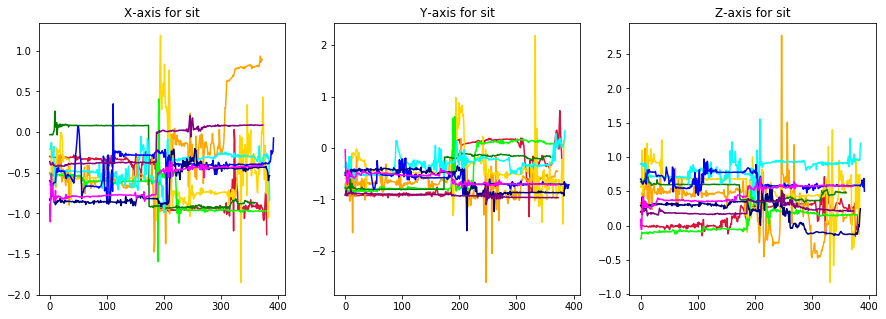

plotting  sleep


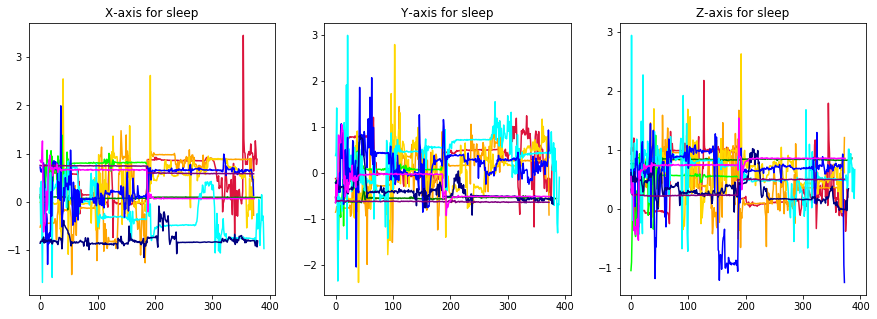

plotting  stand


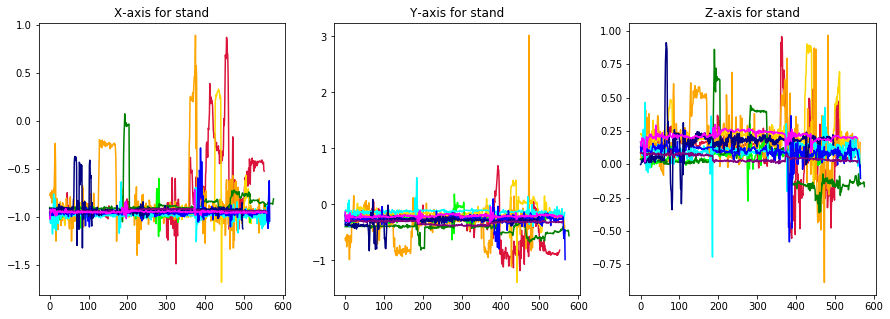

plotting  downstairs


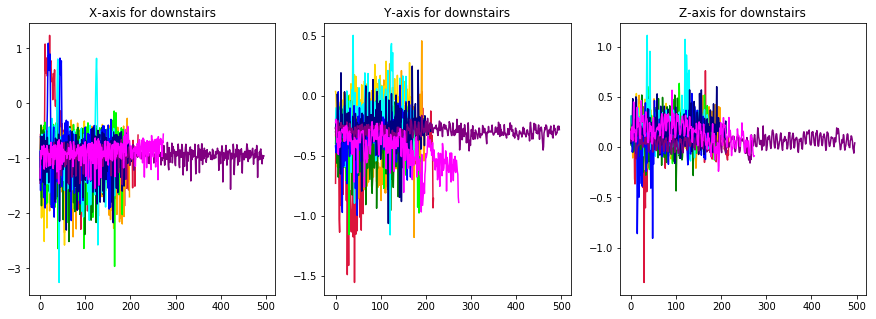

plotting  upstairs


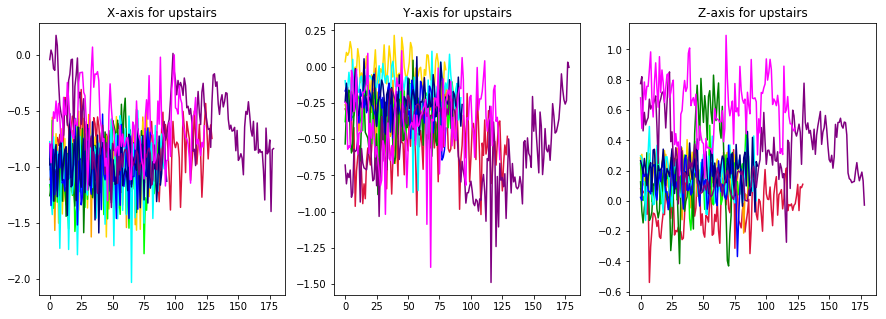

plotting  walk


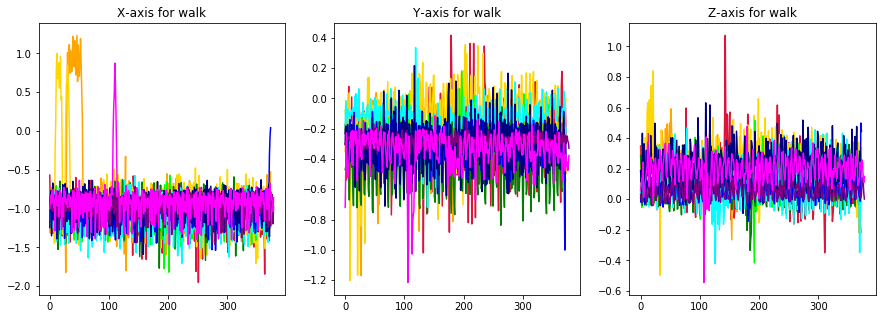

In [189]:
plot_all_label(X_label, y_all, new_label_list, new_label_dict)

plotting  sit


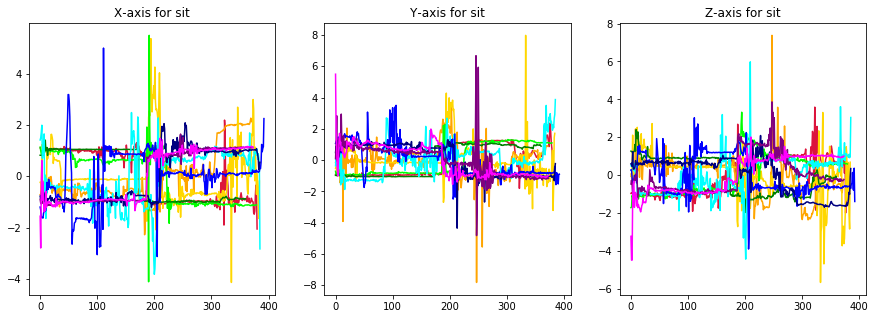

plotting  sleep


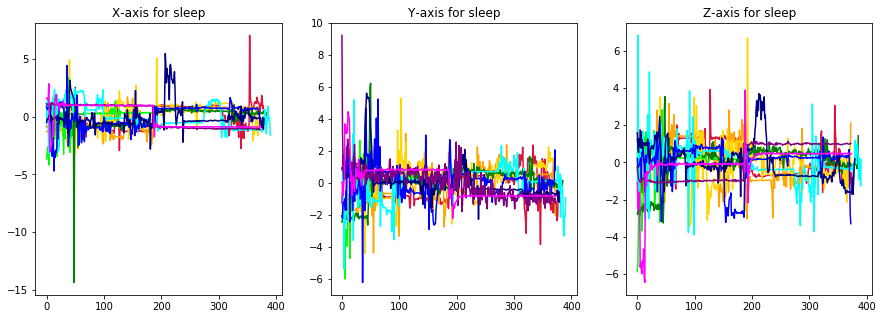

plotting  stand


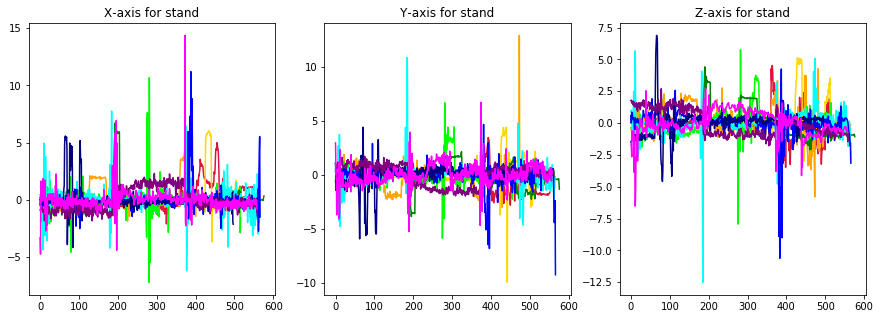

plotting  downstairs


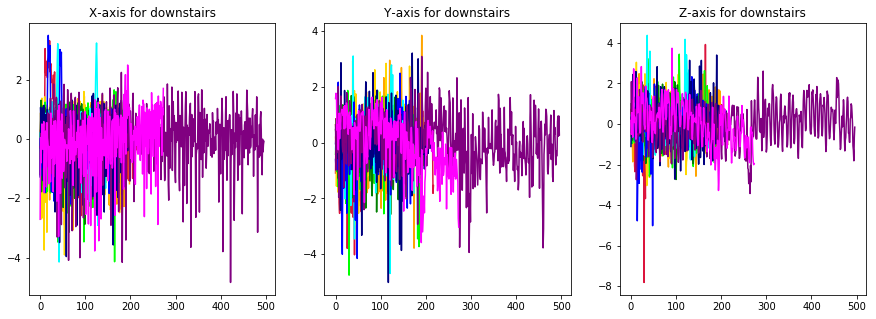

plotting  upstairs


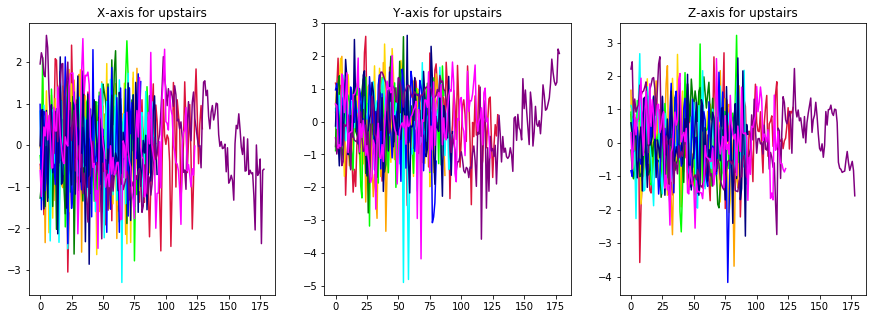

plotting  walk


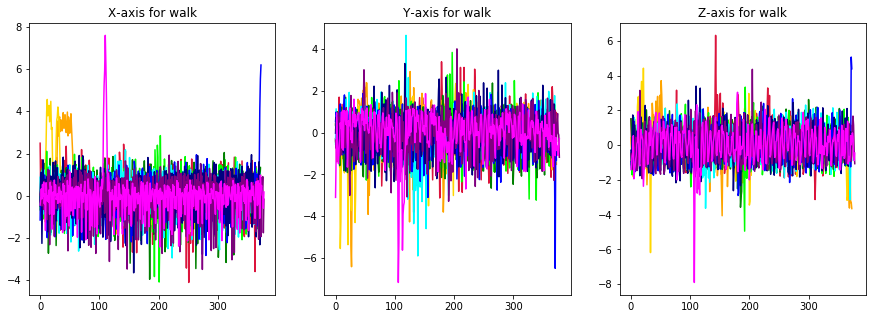

In [157]:
plot_all_label(X_norm, y_all, new_label_list, new_label_dict)

In [158]:
# calculate roll, pitch, yaw and stack them into a list: rpy_list
roll, pitch, yaw = calc_rpy(X_all, subject_id, colors)
rpy = np.array([roll, pitch, yaw]).transpose()

print(rpy.shape)

(19931, 3)


In [162]:
print(X_norm.shape)

X_norm_all = []
first = True

for lb in range(len(label_list)):
    for s in range(len(all_subjects)):
        if(first):
            X_norm_all = X_norm[lb][s]
            first = False
        else:
            X_norm_all = np.vstack((X_norm_all, X_norm[lb][s]))

print(X_norm_all.shape)

(6, 10)
(19931, 3)


PCA


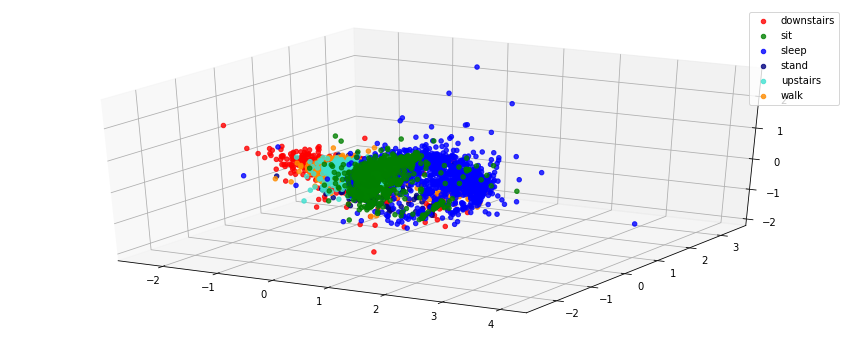

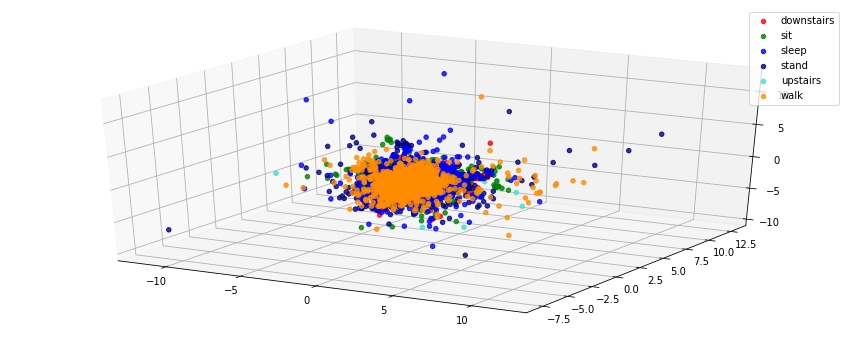

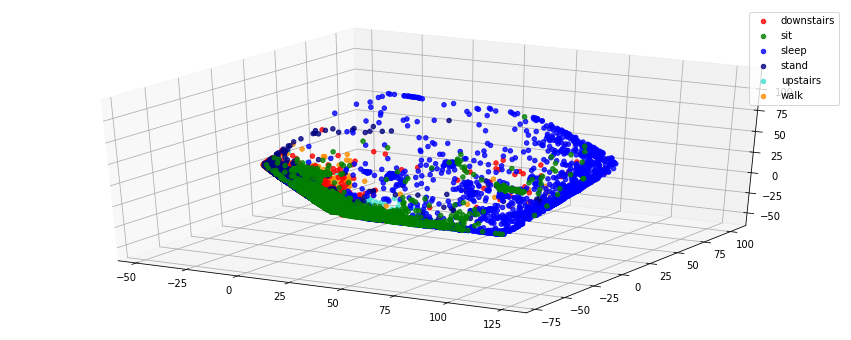

SVD
(19931, 3) (3,) (3, 3)
[147.95 141.41 133.81]


In [215]:
colors = ['r','g','b','navy','turquoise','darkorange']

# apply PCA and LDA to X_norm and rpy
print("PCA")
X_pca = apply_pca(X_all, y_all, label_list)
X_z_pca = apply_pca(X_norm_all, y_all, label_list)
rpy_pca = apply_pca(rpy, y_all, label_list)


# print("LDA")
# X_norm_lda = apply_lda(X_all, y_all, label_list)
# X_z_lda = apply_lda(X_norm_all, y_all, label_list)
# rpy_lda = apply_lda(rpy, y_all, label_list)

# apply svd to X_norm and rpy
print("SVD")
u, s, vh = apply_svd(X_norm_all, y_all, label_list)
u_r, s_r, vh_r = apply_svd(X_norm_all, y_all, label_list)

print(u_r.shape, s_r.shape, vh_r.shape)
print(s_r)

In [170]:
# reshape data before classification
X_svm = np.vstack((rpy_pca))
y_svm = y_all
y_svm = y_svm.reshape((y_svm.shape[-1],))
# y_svm = np.hstack((y_svm, y_svm))
y_svm = y_svm.reshape((y_svm.shape[0],))

print(X_svm.shape, y_svm.shape)

(19931, 3) (19931,)


In [171]:
# Split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.3, random_state=42)

In [187]:
# Using SVM to classify activities
svm_model = svm_classifier(X_svm, y_svm)
print("Finished classification")

y_pred = svm_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print(acc)

Finished classification
0.7321070234113712


In [217]:
print(y_pred)

[2 2 1 ... 5 2 1]


## Confusion Matrix

In [174]:
import itertools

In [180]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [178]:
n_classes = 6
LABELS = ['downstairs','sit','sleep','stand','upstairs','walk']

Confusion matrix, without normalization
Normalized confusion matrix


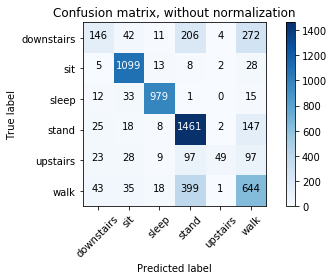

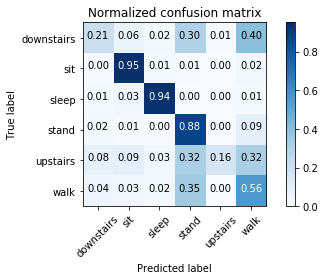

In [181]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Classification Report

In [183]:
from sklearn.metrics import classification_report

In [184]:
print(classification_report(y_test, y_pred, target_names=LABELS))

              precision    recall  f1-score   support

  downstairs       0.57      0.21      0.31       681
         sit       0.88      0.95      0.91      1155
       sleep       0.94      0.94      0.94      1040
       stand       0.67      0.88      0.76      1661
    upstairs       0.84      0.16      0.27       303
        walk       0.54      0.56      0.55      1140

   micro avg       0.73      0.73      0.73      5980
   macro avg       0.74      0.62      0.63      5980
weighted avg       0.73      0.73      0.71      5980



### 1001
* Accuracy of original data: 0.6356

* Accuracy of PCA with original data: 0.6041

* Accuracy of PCA without original data: 0.6400
-------------------------
### All subjects ( test_size=0.3 )
* Accuracy of PCA without original data: 0.6542

## Colors Note

* NaN: Grey
* Stand: Red
* Sit: Green
* Sleep: Yellow
* Walk: Blue
* Walk Downstairs: Orange
* Walk Upstairs: Purple

Headings with [ * ] are the ones where functions are called.